# Import Statements

In [50]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
import tensorflow as tf
from keras.utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")
# init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
import tensorflow as tf
from numpy.random import seed
tf.random.set_seed(1)
seed(1)

# Reading Data and Preprocessing

In [51]:
data = pd.read_csv('./Cleaned_data.csv')

In [52]:
data.shape

(1624492, 6)

In [53]:
data.head(5)

,start_station_id,started_at,start_station_name,start_lat,start_lng,Rides
0,3138.09,2021-02-04,58 St & 2 Ave - Brooklyn Army Terminal Vaccina...,40.644512,-74.021506,2
1,3138.09,2021-02-05,58 St & 2 Ave - Brooklyn Army Terminal Vaccina...,40.644512,-74.021506,1
2,3138.09,2021-02-06,58 St & 2 Ave - Brooklyn Army Terminal Vaccina...,40.644512,-74.021506,2
3,3138.09,2021-02-10,58 St & 2 Ave - Brooklyn Army Terminal Vaccina...,40.644512,-74.021506,1
4,3138.09,2021-02-11,58 St & 2 Ave - Brooklyn Army Terminal Vaccina...,40.644512,-74.021506,1


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624492 entries, 0 to 1624491
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   start_station_id    1624492 non-null  object 
 1   started_at          1624492 non-null  object 
 2   start_station_name  1624492 non-null  object 
 3   start_lat           1624492 non-null  float64
 4   start_lng           1624492 non-null  float64
 5   Rides               1624492 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 74.4+ MB


In [55]:
data['start_station_id'] = data['start_station_id'].astype(str)
data['started_at'] = pd.to_datetime(data['started_at'])

In [56]:
data.groupby('start_station_id').agg({
    'started_at': pd.Series.nunique,
}).sort_values(by='started_at', ascending=False)

,started_at
start_station_id,
4404.1,667
5300.05,667
5156.05,667
5523.02,667
4175.15,667
...,...
4074.14,1
3999.06,1
8419.03,1


In [57]:
test_df = data[data['start_station_id'] == '6688.01']

test_df.shape

(1115, 6)

In [58]:
df = test_df.groupby('started_at').agg({
    'Rides': 'sum',
}).reset_index()

In [59]:
df.sort_values(by='started_at', inplace=True)

In [60]:
df.shape

(666, 2)

In [61]:
max_size = df.shape[0]
test_size = 0.135

idx = int(max_size-(max_size*test_size))

train = df.iloc[0:idx,:]
test = df.iloc[idx:,:]

train.shape, test.shape

((576, 2), (90, 2))

In [62]:
print('Min date from train set: %s' % train['started_at'].min().date())
print('Max date from train set: %s' % train['started_at'].max().date())

Min date from train set: 2021-02-03
Max date from train set: 2022-09-01


In [63]:
print('Min date from train set: %s' % test['started_at'].min().date())
print('Max date from train set: %s' % test['started_at'].max().date())

Min date from train set: 2022-09-02
Max date from train set: 2022-11-30


In [64]:
lag_size = (test['started_at'].max().date() - train['started_at'].max().date()).days
print('Max date from train set: %s' % train['started_at'].max().date())
print('Max date from test set: %s' % test['started_at'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2022-09-01
Max date from test set: 2022-11-30
Forecast lag size 90


In [65]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [66]:
window = 29
lag_size = 30
lag = lag_size
series = series_to_supervised(train.drop('started_at', axis=1), window=window, lag=lag)
test_series = series_to_supervised(test.drop('started_at', axis=1), window=window, lag=lag)


print(series.shape, test_series.shape)
series.head()

(517, 31) (31, 31)


,Rides(t-29),Rides(t-28),Rides(t-27),Rides(t-26),Rides(t-25),Rides(t-24),Rides(t-23),Rides(t-22),Rides(t-21),Rides(t-20),...,Rides(t-8),Rides(t-7),Rides(t-6),Rides(t-5),Rides(t-4),Rides(t-3),Rides(t-2),Rides(t-1),Rides(t),Rides(t+30)
29,1.0,6.0,2.0,9.0,2.0,5.0,3.0,7.0,4.0,6.0,...,14.0,14.0,8.0,8.0,7.0,9.0,10.0,18.0,11,19.0
30,6.0,2.0,9.0,2.0,5.0,3.0,7.0,4.0,6.0,7.0,...,14.0,8.0,8.0,7.0,9.0,10.0,18.0,11.0,14,12.0
31,2.0,9.0,2.0,5.0,3.0,7.0,4.0,6.0,7.0,8.0,...,8.0,8.0,7.0,9.0,10.0,18.0,11.0,14.0,21,18.0
32,9.0,2.0,5.0,3.0,7.0,4.0,6.0,7.0,8.0,5.0,...,8.0,7.0,9.0,10.0,18.0,11.0,14.0,21.0,13,18.0
33,2.0,5.0,3.0,7.0,4.0,6.0,7.0,8.0,5.0,6.0,...,7.0,9.0,10.0,18.0,11.0,14.0,21.0,13.0,12,22.0


In [67]:
labels_col = 'Rides(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)
X_test = test_series.drop(labels_col, axis=1)


X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.135, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
print('Test set shape', X_test.shape)

X_train.head()

Train set shape (447, 30)
Validation set shape (70, 30)
Test set shape (31, 30)


,Rides(t-29),Rides(t-28),Rides(t-27),Rides(t-26),Rides(t-25),Rides(t-24),Rides(t-23),Rides(t-22),Rides(t-21),Rides(t-20),...,Rides(t-9),Rides(t-8),Rides(t-7),Rides(t-6),Rides(t-5),Rides(t-4),Rides(t-3),Rides(t-2),Rides(t-1),Rides(t)
223,22.0,29.0,25.0,28.0,26.0,25.0,6.0,17.0,27.0,25.0,...,27.0,26.0,21.0,29.0,21.0,22.0,23.0,25.0,20.0,21
337,25.0,23.0,19.0,21.0,16.0,17.0,15.0,16.0,22.0,27.0,...,22.0,11.0,10.0,18.0,13.0,16.0,14.0,20.0,10.0,18
39,7.0,8.0,5.0,6.0,11.0,6.0,4.0,11.0,8.0,7.0,...,14.0,21.0,13.0,12.0,12.0,22.0,17.0,23.0,21.0,12
453,12.0,10.0,11.0,6.0,7.0,18.0,21.0,19.0,16.0,22.0,...,31.0,10.0,15.0,16.0,20.0,21.0,22.0,27.0,22.0,10
199,32.0,32.0,24.0,29.0,23.0,35.0,29.0,31.0,17.0,34.0,...,28.0,21.0,29.0,23.0,22.0,29.0,25.0,28.0,26.0,25


# LSTM Model

In [68]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [69]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))


print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (447, 30, 1)
Validation set shape (70, 30, 1)
Test set shape (31, 30, 1)


In [70]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
lstm_history = model_lstm.fit(
    X_train_series,
    Y_train,
    validation_data=(X_valid_series, Y_valid),
    epochs=epochs,
    verbose=2
)

Epoch 1/40
14/14 - 2s - loss: 353.0139 - val_loss: 148.9201 - 2s/epoch - 130ms/step
Epoch 2/40
14/14 - 0s - loss: 126.6435 - val_loss: 109.6273 - 196ms/epoch - 14ms/step
Epoch 3/40
14/14 - 0s - loss: 100.5908 - val_loss: 94.1342 - 194ms/epoch - 14ms/step
Epoch 4/40
14/14 - 0s - loss: 93.4216 - val_loss: 88.5590 - 204ms/epoch - 15ms/step
Epoch 5/40
14/14 - 0s - loss: 85.1583 - val_loss: 78.4552 - 207ms/epoch - 15ms/step
Epoch 6/40
14/14 - 0s - loss: 79.6650 - val_loss: 68.2438 - 194ms/epoch - 14ms/step
Epoch 7/40
14/14 - 0s - loss: 72.8300 - val_loss: 62.3198 - 196ms/epoch - 14ms/step
Epoch 8/40
14/14 - 0s - loss: 70.5686 - val_loss: 60.4909 - 192ms/epoch - 14ms/step
Epoch 9/40
14/14 - 0s - loss: 67.7807 - val_loss: 62.8530 - 189ms/epoch - 14ms/step
Epoch 10/40
14/14 - 0s - loss: 64.3397 - val_loss: 68.6540 - 213ms/epoch - 15ms/step
Epoch 11/40
14/14 - 0s - loss: 67.9490 - val_loss: 65.8170 - 189ms/epoch - 13ms/step
Epoch 12/40
14/14 - 0s - loss: 65.7061 - val_loss: 65.5675 - 194ms/epoc

# CNN-LSTM Model

In [72]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))

print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

Train set shape (447, 2, 15, 1)
Validation set shape (70, 2, 15, 1)
Test set shape (31, 2, 15, 1)


In [73]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse')

In [74]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
14/14 - 2s - loss: 157.9299 - val_loss: 78.5520 - 2s/epoch - 150ms/step
Epoch 2/40
14/14 - 0s - loss: 78.3605 - val_loss: 74.9336 - 104ms/epoch - 7ms/step
Epoch 3/40
14/14 - 0s - loss: 74.1865 - val_loss: 67.3315 - 96ms/epoch - 7ms/step
Epoch 4/40
14/14 - 0s - loss: 79.1177 - val_loss: 65.6444 - 103ms/epoch - 7ms/step
Epoch 5/40
14/14 - 0s - loss: 67.5777 - val_loss: 106.1965 - 117ms/epoch - 8ms/step
Epoch 6/40
14/14 - 0s - loss: 74.5376 - val_loss: 76.3891 - 112ms/epoch - 8ms/step
Epoch 7/40
14/14 - 0s - loss: 69.9996 - val_loss: 65.6884 - 106ms/epoch - 8ms/step
Epoch 8/40
14/14 - 0s - loss: 74.8836 - val_loss: 95.9955 - 92ms/epoch - 7ms/step
Epoch 9/40
14/14 - 0s - loss: 72.4702 - val_loss: 66.2640 - 125ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 72.8378 - val_loss: 71.8847 - 96ms/epoch - 7ms/step
Epoch 11/40
14/14 - 0s - loss: 70.4747 - val_loss: 74.6068 - 108ms/epoch - 8ms/step
Epoch 12/40
14/14 - 0s - loss: 83.6533 - val_loss: 63.5083 - 113ms/epoch - 8ms/step
Epo

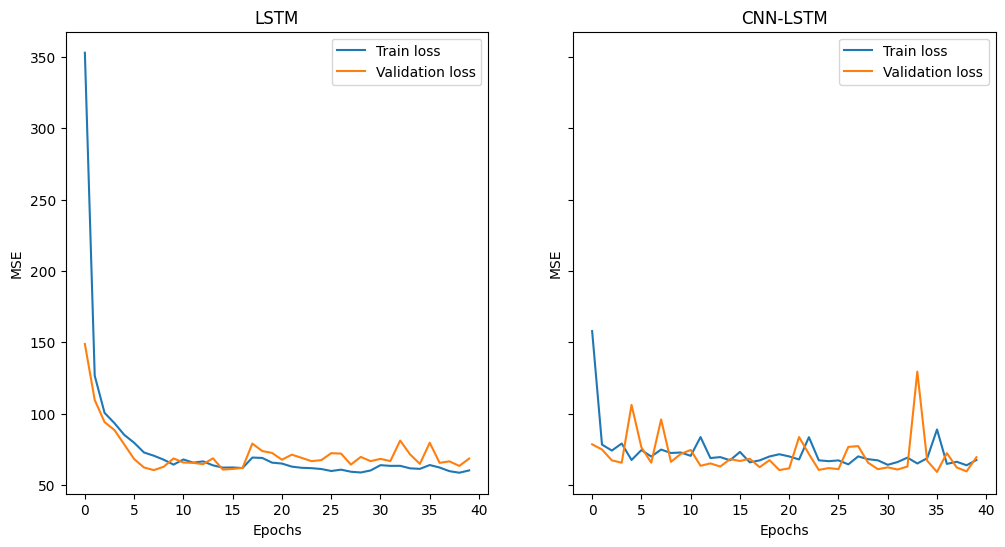

In [75]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(12,6))
ax1, ax2 = axes

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('LSTM')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax2.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN-LSTM')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

plt.show()

In [76]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)
lstm_test_pred = model_lstm.predict(X_test_series)

print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

1/1 [==============================] - 0s 24ms/step
Train rmse: 7.570391998014173
Validation rmse: 8.281362925159817


In [77]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
cnn_lstm_test_pred = model_cnn_lstm.predict(X_test_series_sub)

print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

1/1 [==============================] - 0s 28ms/step
Train rmse: 7.9217012436341765
Validation rmse: 8.339927169877754


**ARIMA Model**

In [78]:
df

,started_at,Rides
0,2021-02-03,1
1,2021-02-04,6
2,2021-02-05,2
3,2021-02-06,9
4,2021-02-07,2
...,...,...
661,2022-11-26,15
662,2022-11-27,13
663,2022-11-28,13
664,2022-11-29,14


In [79]:
df.set_index('started_at', inplace=True)

In [80]:
from sklearn.linear_model import LinearRegression
class ARIMA_Model:
    def __init__(self):
        pass

    @staticmethod
    def _predictive_model(dataframe, lag_terms, value_column, prediction_column, split_ratio=0.8):
        _data = dataframe.copy()

        # Creating lagged values
        for i in range(1, lag_terms + 1):
            _data[f'lagged_{i}'] = _data[value_column].shift(i)
        _data.dropna(inplace=True)

        _split_size = int(split_ratio * _data.shape[0])

        # Dividing data into training and testing sets
        _train_data = pd.DataFrame(_data[:_split_size])
        _test_data = pd.DataFrame(_data[_split_size:])

        # Extracting X and Y for training
        X_train = _train_data.iloc[:, 1:].values.reshape(-1, lag_terms)
        y_train = _train_data.iloc[:, 0].values.reshape(-1, 1)

        # Extracting X and Y for testing
        X_test = _test_data.iloc[:, 1:].values.reshape(-1, lag_terms)
        y_test = _test_data.iloc[:, 0].values.reshape(-1, 1)

        # Applying linear regression
        linear_model = LinearRegression()
        linear_model.fit(X_train, y_train)

        coefficients = linear_model.coef_.T
        y_intercept = linear_model.intercept_
        _train_data[prediction_column] = X_train.dot(coefficients) + y_intercept

        _test_data[prediction_column] = X_test.dot(coefficients) + y_intercept

        error = np.sqrt(mean_squared_error(y_test, _test_data[prediction_column]))

        combined_data = pd.concat([_train_data, _test_data])[[value_column, prediction_column]]
        return combined_data, coefficients, y_intercept, error, abs(_test_data[prediction_column].mean())

    @staticmethod
    def AutoRegression(data, order, value_col='value', pred_col='predicted', split_ratio=0.8):
        return ARIMA_Model._predictive_model(data, order, value_col, pred_col, split_ratio)

    @staticmethod
    def Integration(data, value_col='value', function=None):
        _data = data.copy()
        if function:
            return pd.DataFrame(function(_data[value_col])).dropna()
        return _data

    @staticmethod
    def MovingAverage(data, order, value_col='value', input_pred_col='predicted', output_pred_col='ma_predicted', split_ratio=0.8):
        _data = data.copy()
        _data['error'] = _data[value_col] - _data[input_pred_col]
        return ARIMA_Model._predictive_model(_data[['error']], order, 'error', output_pred_col, split_ratio)

    def fit_model(self, data, p, q, value_column, split_ratio, stationary_function=None):
        _data = data.copy()
        stationary_data = ARIMA_Model.Integration(_data, value_column, stationary_function)

        ar_data, ar_coeff, ar_intercept, ar_error, ar_avg_pred = ARIMA_Model.AutoRegression(stationary_data, p, value_column, 'ar_pred', split_ratio)

        ma_data, ma_coeff, ma_intercept, ma_error, ma_avg_pred = ARIMA_Model.MovingAverage(ar_data, q, value_column, 'ar_pred', 'ma_pred', split_ratio)

        stationary_data['final_prediction'] = ar_data['ar_pred'] + ma_data['ma_pred']
        return stationary_data.dropna(), ar_coeff, ar_intercept, ma_coeff, ma_intercept, ar_error, ma_error, ar_avg_pred, ma_avg_pred


In [81]:
arima_model = ARIMA_Model()


In [82]:
P = 2
Q = 2

In [83]:
stationary_fn = lambda x: x.diff().diff()
def reverse_stationary_fn(ori_x, new_x):
    x = new_x.copy()
    x += ori_x.shift(1)
    x += ori_x.diff().shift(1)
    return x

min_ar_rmse = float('inf')
min_ma_rmse = float('inf')
best_ar_mean_pred = None
best_ma_mean_pred = None
best_p = 1
best_q = 1

for i in range(1, 21):
    final_predictions, \
        ar_theta, ar_intercept, \
        ma_theta, ma_intercept, \
        ar_rmse, ma_rmse, \
        ar_mean_pred, ma_mean_pred = arima_model.fit_model(df, i, best_q, 'Rides', 0.8, stationary_fn)

    if ar_rmse < min_ar_rmse:
        min_ar_rmse = ar_rmse
        best_ar_mean_pred = ar_mean_pred
        best_p = i


for j in range(1, 21):
    final_predictions, \
        ar_theta, ar_intercept, \
        ma_theta, ma_intercept, \
        ar_rmse, ma_rmse, \
        ar_mean_pred, ma_mean_pred = arima_model.fit_model(df, best_p, j, 'Rides', 0.8, stationary_fn)

    if ma_rmse < min_ma_rmse:
        min_ma_rmse = ma_rmse
        best_ma_mean_pred = ma_mean_pred
        best_q = j

In [84]:
print(f'Min RMSE of AR model: {min_ar_rmse} (relative err: {min_ar_rmse/best_ar_mean_pred}). Best P: {best_p}')
print(f'Min RMSE of MA model: {min_ma_rmse} (relative err: {min_ma_rmse/best_ma_mean_pred}). Best Q: {best_q}')

Min RMSE of AR model: 8.018543657152549 (relative err: 304.2856537303157). Best P: 20
Min RMSE of MA model: 7.84452225869154 (relative err: 46.399322218685526). Best Q: 13


In [85]:
final_predictions, \
ar_theta, ar_intercept, \
ma_theta, ma_intercept, \
ar_rmse, ma_rmse, \
ar_mean_pred, ma_mean_pred = arima_model.fit_model(df, 14, 12, 'Rides', 0.8, stationary_fn)

<Axes: xlabel='started_at'>

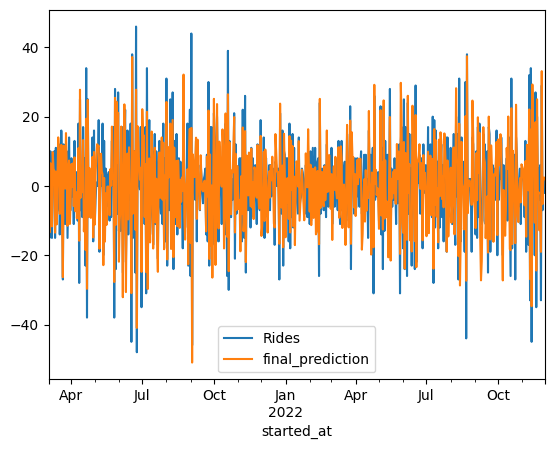

In [86]:
final_predictions.plot()


**SARIMA Model**

In [87]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

In [90]:
split_point = int(len(df) * 0.8)
train, test = df[0:split_point], df[split_point:]

In [91]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # assuming a yearly seasonality

model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [92]:
predictions = model_fit.forecast(steps=len(test))
rmse = sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

RMSE: 16.446498636328744


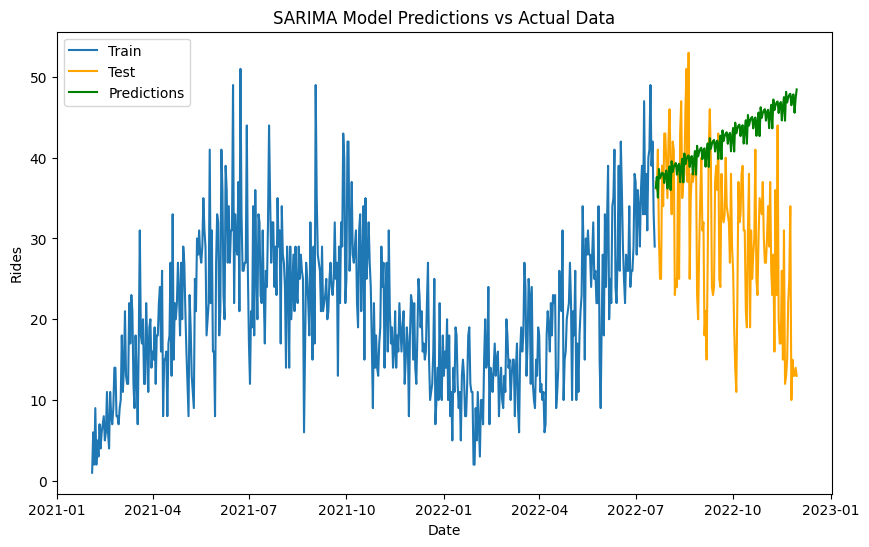

In [93]:
plt.figure(figsize=(10,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, predictions, label='Predictions', color='green')
plt.title('SARIMA Model Predictions vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Rides')
plt.legend()
plt.show()